# Analyzing MLP in Transformer-based Decision Making

This notebook explores the Multi-Layer Perception mechanisms in transformer models trained on decision sequences. We'll visualize and analyze what is represented in the Multi-Layer Perceptrons that lead to decision-making outputs (R, r, L, l).


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from transformer.transformer import MLP, GPT, GPTConfig


In [3]:

# Choose a run number
run = 1

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Load the model
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")


# Print model configuration details
print(f"Number of layers: {config.n_layer}")
print(f"Number of attention heads: {config.n_head}")
print(f"Embedding dimension: {config.n_embd}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Block size (context length): {config.block_size}")

# Create a dummy MLP for analysis
dummy_mlp = MLP(config)

# Analyze MLP dimensions
mlp_input_dim = config.n_embd
mlp_hidden_dim = 4 * config.n_embd  # From the MLP implementation
mlp_output_dim = config.n_embd

print(f"\nMLP Dimensions Analysis:")
print(f"MLP Input Dimension: {mlp_input_dim}")
print(f"MLP Hidden Dimension: {mlp_hidden_dim}")
print(f"MLP Output Dimension: {mlp_output_dim}")

Using cuda device
Total number of parameters: 968
Number of layers: 1
Number of attention heads: 1
Embedding dimension: 8
Vocabulary size: 4
Block size (context length): 6

MLP Dimensions Analysis:
MLP Input Dimension: 8
MLP Hidden Dimension: 32
MLP Output Dimension: 8


In [4]:
# Analyze MLP parameters
mlp_params = sum(p.numel() for p in dummy_mlp.parameters() if p.requires_grad)
print(f"\nMLP Parameters: {mlp_params}")

# Detailed breakdown of MLP parameters
fc_params = dummy_mlp.c_fc.weight.numel() + (dummy_mlp.c_fc.bias.numel() if dummy_mlp.c_fc.bias is not None else 0)
proj_params = dummy_mlp.c_proj.weight.numel() + (dummy_mlp.c_proj.bias.numel() if dummy_mlp.c_proj.bias is not None else 0)

print(f"First linear layer (c_fc) parameters: {fc_params}")
print(f"  - Weight shape: {dummy_mlp.c_fc.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_fc.bias.shape if dummy_mlp.c_fc.bias is not None else 'None'}")
print(f"Projection layer (c_proj) parameters: {proj_params}")
print(f"  - Weight shape: {dummy_mlp.c_proj.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_proj.bias.shape if dummy_mlp.c_proj.bias is not None else 'None'}")

# Calculate percentage of parameters in MLP vs. total model
mlp_percentage = (mlp_params * config.n_layer / total_params) * 100

print(f"Each transformer block contains one MLP")
print(f"Total MLPs in model: {config.n_layer}")
print(f"Total parameters in all MLPs: {mlp_params * config.n_layer}")
print(f"MLPs account for {mlp_percentage:.2f}% of total model parameters")


MLP Parameters: 552
First linear layer (c_fc) parameters: 288
  - Weight shape: torch.Size([32, 8])
  - Bias shape: torch.Size([32])
Projection layer (c_proj) parameters: 264
  - Weight shape: torch.Size([8, 32])
  - Bias shape: torch.Size([8])
Each transformer block contains one MLP
Total MLPs in model: 1
Total parameters in all MLPs: 552
MLPs account for 57.02% of total model parameters


# 1. Extract MLP activations for different sequences


In [5]:
from utils.parse_data import parse_simulated_data, get_data_filenames, add_sequence_columns

def get_mlp_activations(model, input_seq, vocab, stoi):
    """Extract MLP activations for a given input sequence"""
    # Convert sequence to tensor
    indices = [stoi[c] for c in input_seq]
    tokens = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # Storage for activations
    mlp_activations = []
    
    # Register hook to capture activations
    def hook_fn(module, input, output):
        mlp_activations.append(input[0].detach().cpu().numpy())
    
    # Register the hook on MLP intermediate activation (after first linear layer)
    hooks = []
    for block in model.transformer.h:
        handle = block.mlp.c_fc.register_forward_hook(hook_fn)
        hooks.append(handle)
    
    # Forward pass
    with torch.no_grad():
        model(tokens)
    
    # Remove hooks
    for handle in hooks:
        handle.remove()
    
    return mlp_activations

T = model_info['dataloader']['Sequence length (T)']
print(f"Sequence length: {T}")
# Get common sequences from data for analysis
events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
events = add_sequence_columns(events, T)
vc = events[f'seq{T}_RL'].value_counts()
sequences = vc[vc > 50].index.tolist()[:10]  # Top 10 common sequences
print(f"Analyzing sequences:\n{sequences}")

# Define vocabulary mapping
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}

# Collect MLP activations for each sequence
all_activations = {}
for seq in sequences:
    all_activations[seq] = get_mlp_activations(model, seq, vocab, stoi)

Sequence length: 6


Analyzing sequences:
['RRRRRR', 'LLLLLL', 'RRRRRr', 'RRRRrR', 'RRRrRR', 'RRrRRR', 'RrRRRR', 'rRRRRR', 'LLLLLR', 'RLLLLL']


# 2. Analyze which neurons are most active for different decisions

In [6]:
# Prepare a dataframe to hold neuron activations for the last position (decision point)
import pandas as pd

# Extract last position activations (for the final decision)
last_pos_activations = {}
for seq in sequences:
    # Get the layer 0 MLP activation (for the last token position)
    last_pos_activations[seq] = all_activations[seq][0][0, -1, :]

# Convert to DataFrame for easier analysis
activation_df = pd.DataFrame(last_pos_activations)

# Find the most active neurons for each sequence
top_neurons = {}
for seq in sequences:
    # Get top 5 neurons with highest activation
    top_idx = np.argsort(activation_df[seq].values)[-5:]
    top_values = activation_df[seq].values[top_idx]
    top_neurons[seq] = list(zip(top_idx, top_values))

print("Top active neurons for each sequence:")
for seq, neurons in top_neurons.items():
    print(f"{seq}: {neurons}")

Top active neurons for each sequence:
RRRRRR: [(6, -0.13050804), (0, 0.39556324), (1, 0.8553954), (3, 1.3412837), (7, 1.4582294)]
LLLLLL: [(0, 0.1653989), (6, 0.4851403), (5, 0.6088402), (4, 1.2386239), (2, 1.595716)]
RRRRRr: [(0, -0.6649808), (6, -0.1729658), (1, 1.0008737), (3, 1.209892), (7, 1.9489485)]
RRRRrR: [(6, -0.14409669), (1, 0.23411195), (0, 0.5283774), (3, 1.5020847), (7, 1.5996604)]
RRRrRR: [(6, -0.14046642), (1, 0.370126), (0, 0.496516), (3, 1.4757086), (7, 1.5742403)]
RRrRRR: [(6, -0.13834569), (0, 0.47047317), (1, 0.49840632), (3, 1.4455024), (7, 1.5472934)]
RrRRRR: [(6, -0.13835353), (0, 0.4539876), (1, 0.6057657), (3, 1.41522), (7, 1.522306)]
rRRRRR: [(6, -0.13769333), (0, 0.44260463), (1, 0.66824746), (3, 1.3970599), (7, 1.5069598)]
LLLLLR: [(4, -0.04477329), (2, 0.2385383), (3, 0.6570104), (7, 0.92497474), (0, 1.8869725)]
RLLLLL: [(0, 0.050946347), (6, 0.59666663), (5, 0.68417007), (4, 1.1638521), (2, 1.5869818)]


# 3. Analyze neuron specialization - do certain neurons always activate for R vs L?

Neurons specialized for R decisions: [0 1 3 7]
Neurons specialized for L decisions: [2 4 5 6]


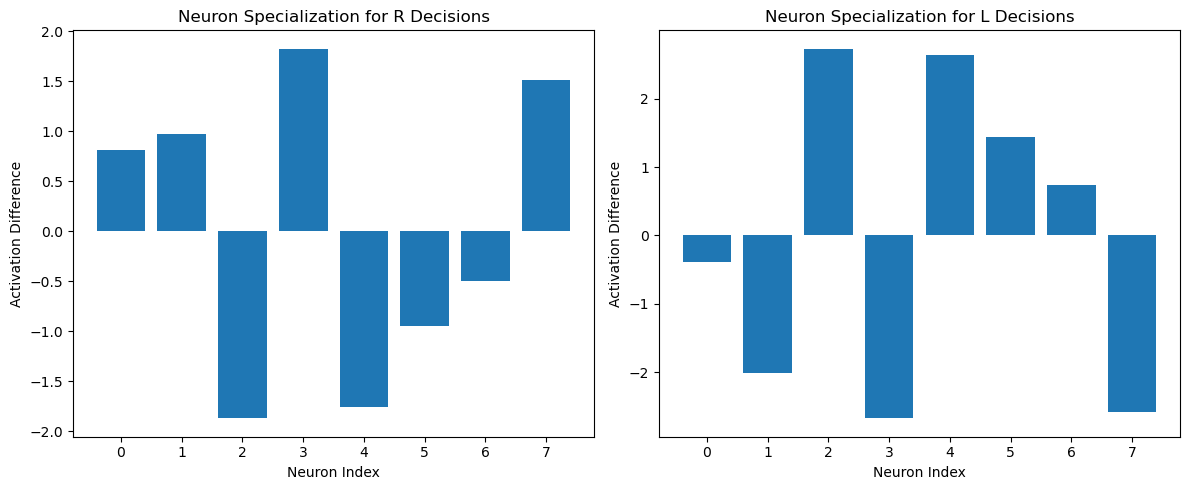

In [7]:
# Group sequences by their last token (which represents the decision)
R_sequences = [seq for seq in sequences if seq[-1] == 'R']
r_sequences = [seq for seq in sequences if seq[-1] == 'r']
L_sequences = [seq for seq in sequences if seq[-1] == 'L']
l_sequences = [seq for seq in sequences if seq[-1] == 'l']

# Function to find neurons that strongly activate for specific decisions
def find_decision_neurons(decision_seqs, other_seqs, threshold=0.5):
    """Find neurons that activate strongly for specific decision sequences"""
    # Average activation for decision sequences
    decision_act = np.mean([last_pos_activations[seq] for seq in decision_seqs], axis=0)
    
    # Average activation for other sequences
    other_act = np.mean([last_pos_activations[seq] for seq in other_seqs], axis=0)
    
    # Find neurons with significantly higher activation for decision sequences
    diff = decision_act - other_act
    decision_neurons = np.where(diff > threshold)[0]
    
    return decision_neurons, diff

# Find neurons specialized for each decision
R_neurons, R_diff = find_decision_neurons(R_sequences, r_sequences + L_sequences + l_sequences)
L_neurons, L_diff = find_decision_neurons(L_sequences, R_sequences + r_sequences + l_sequences)

print(f"Neurons specialized for R decisions: {R_neurons}")
print(f"Neurons specialized for L decisions: {L_neurons}")

# Visualize the neuron specialization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(R_diff)), R_diff)
plt.title('Neuron Specialization for R Decisions')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Difference')

plt.subplot(1, 2, 2)
plt.bar(range(len(L_diff)), L_diff)
plt.title('Neuron Specialization for L Decisions')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Difference')
plt.tight_layout()
plt.show()

/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Layer: input
Neurons specialized for R decisions: [3 7]
Neurons specialized for r decisions: []
Neurons specialized for L decisions: [2 4]
Neurons specialized for l decisions: []


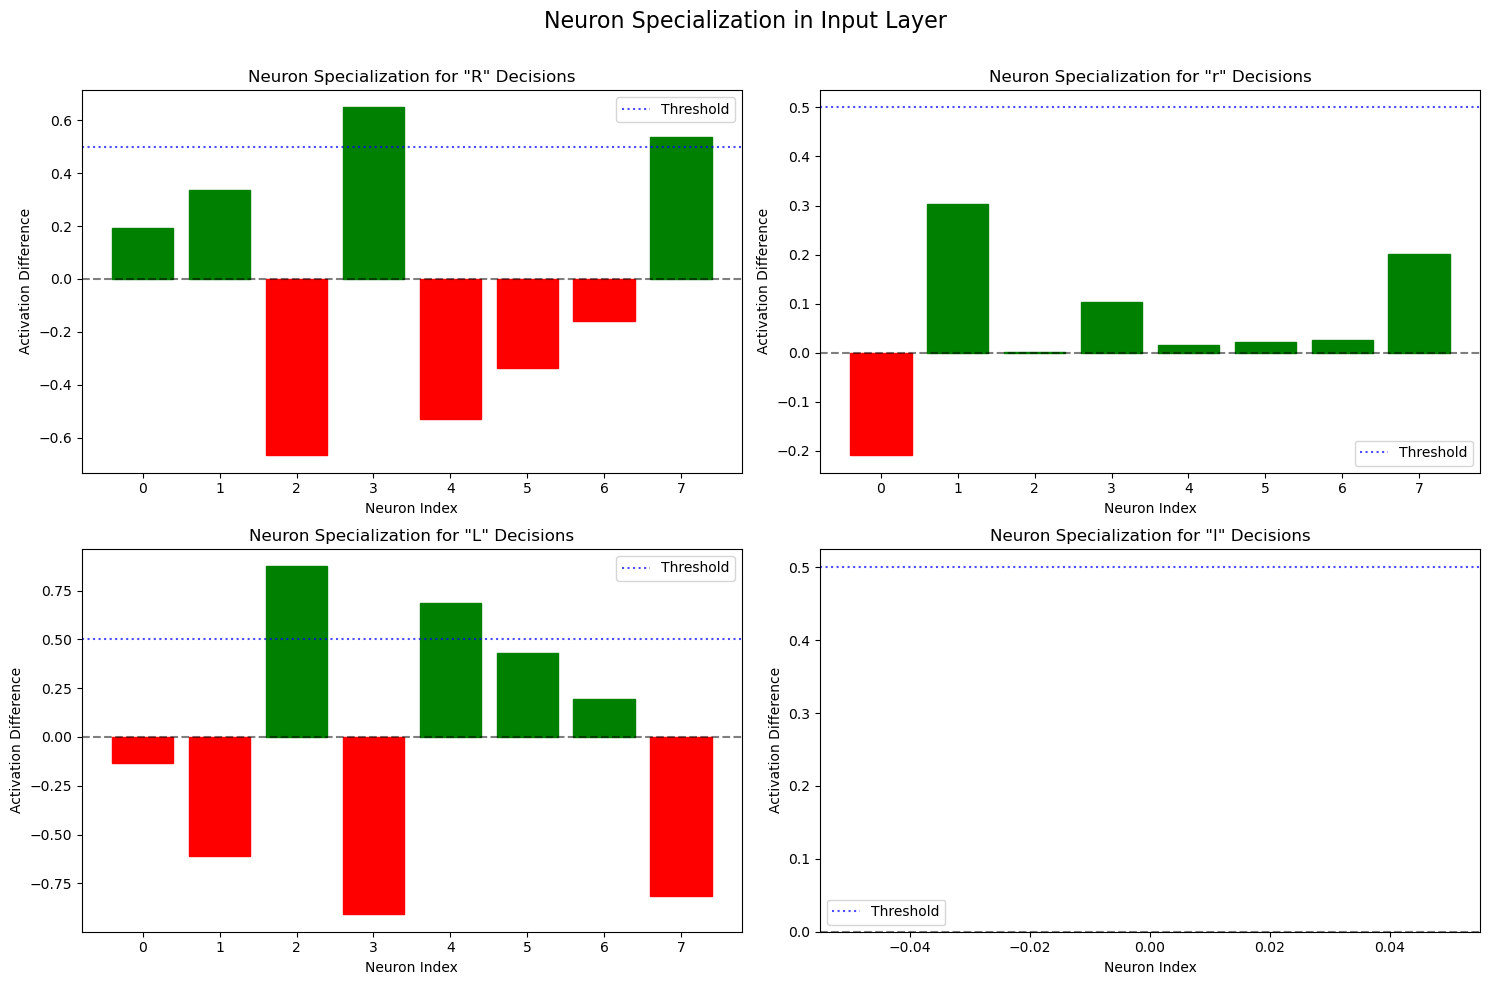

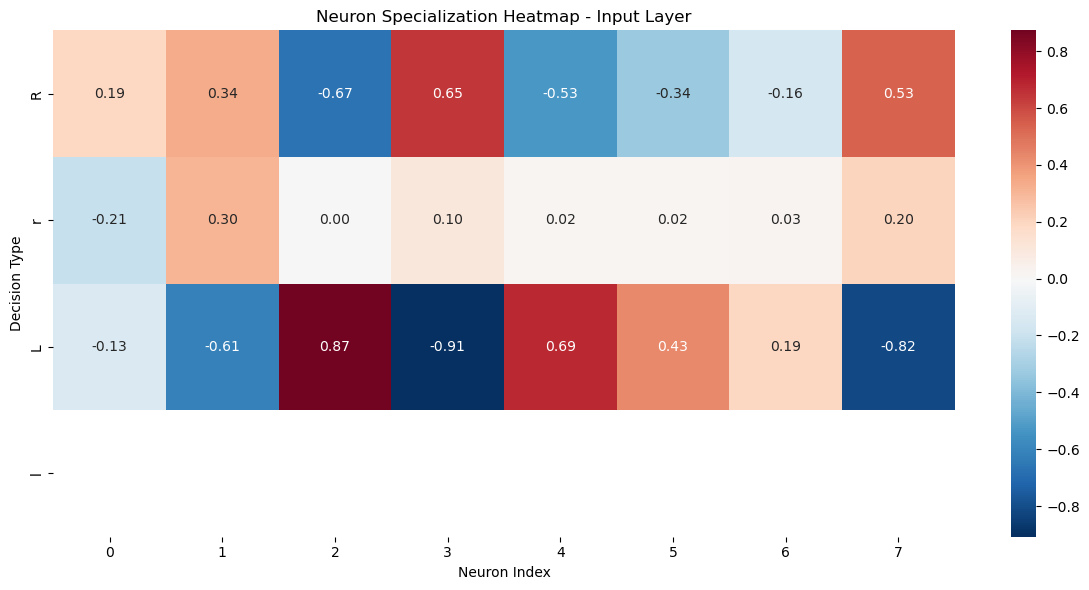

/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Layer: hidden
Neurons specialized for R decisions: [ 7 10 13 15 18 20 21 29]
Neurons specialized for r decisions: []
Neurons specialized for L decisions: [ 0  3  9 19 26 28]
Neurons specialized for l decisions: []


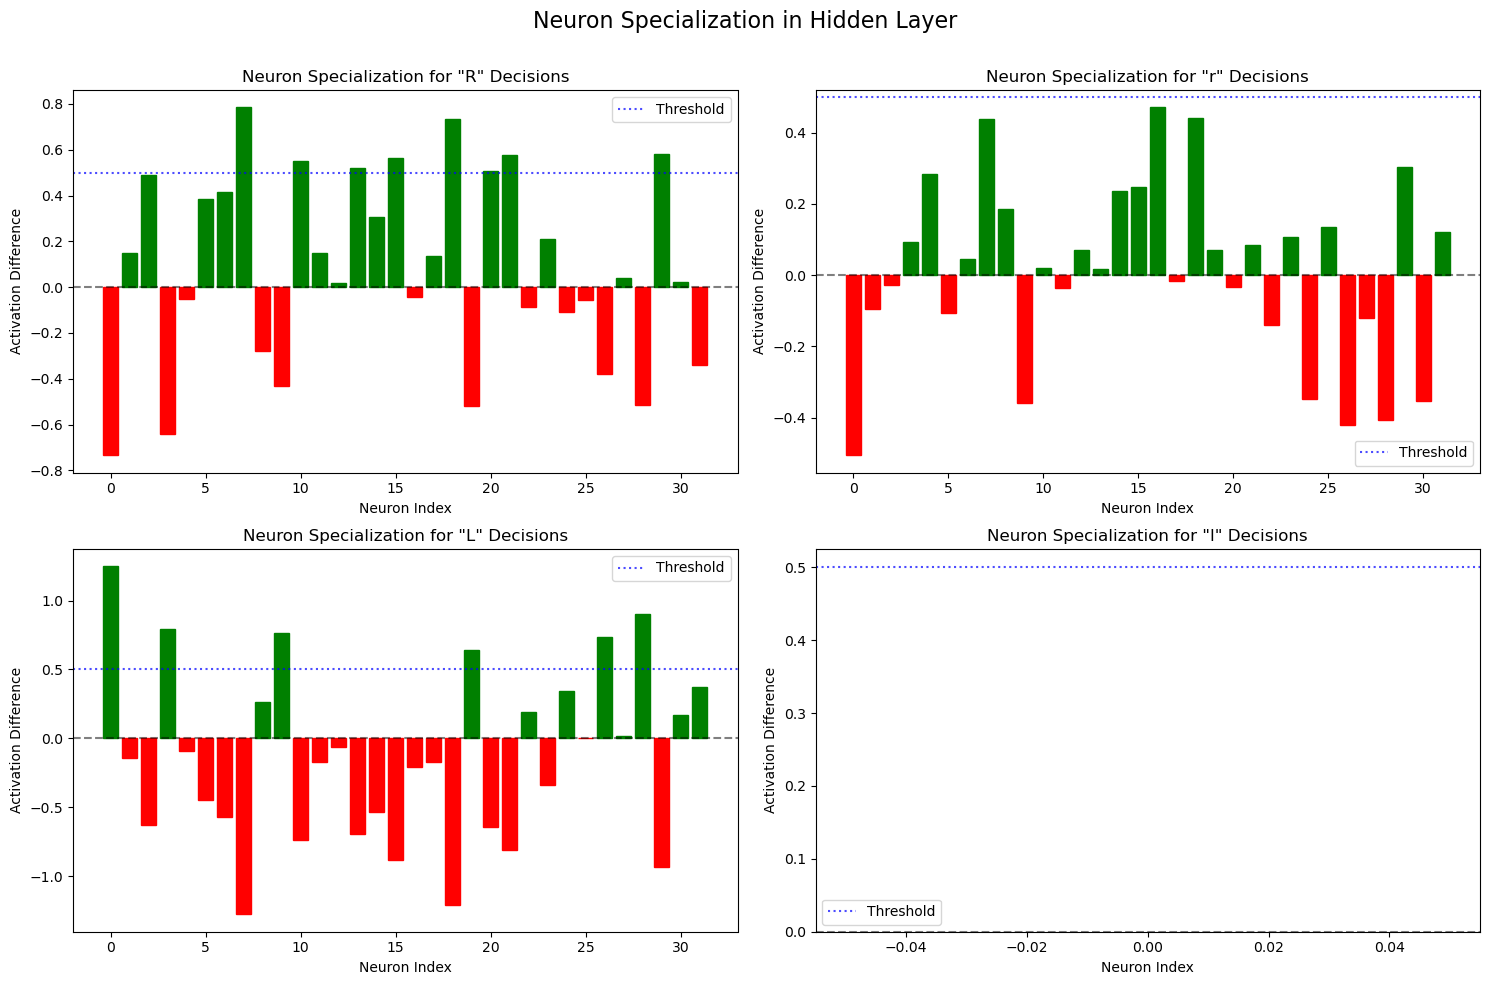

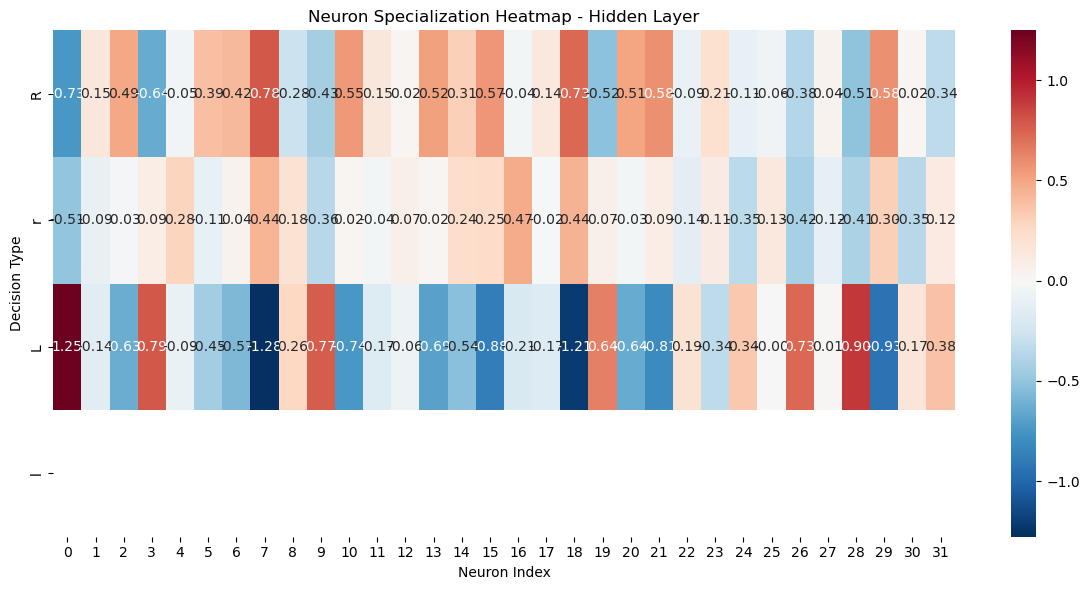

/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Layer: gelu
Neurons specialized for R decisions: []
Neurons specialized for r decisions: []
Neurons specialized for L decisions: [ 0  9 28]
Neurons specialized for l decisions: []


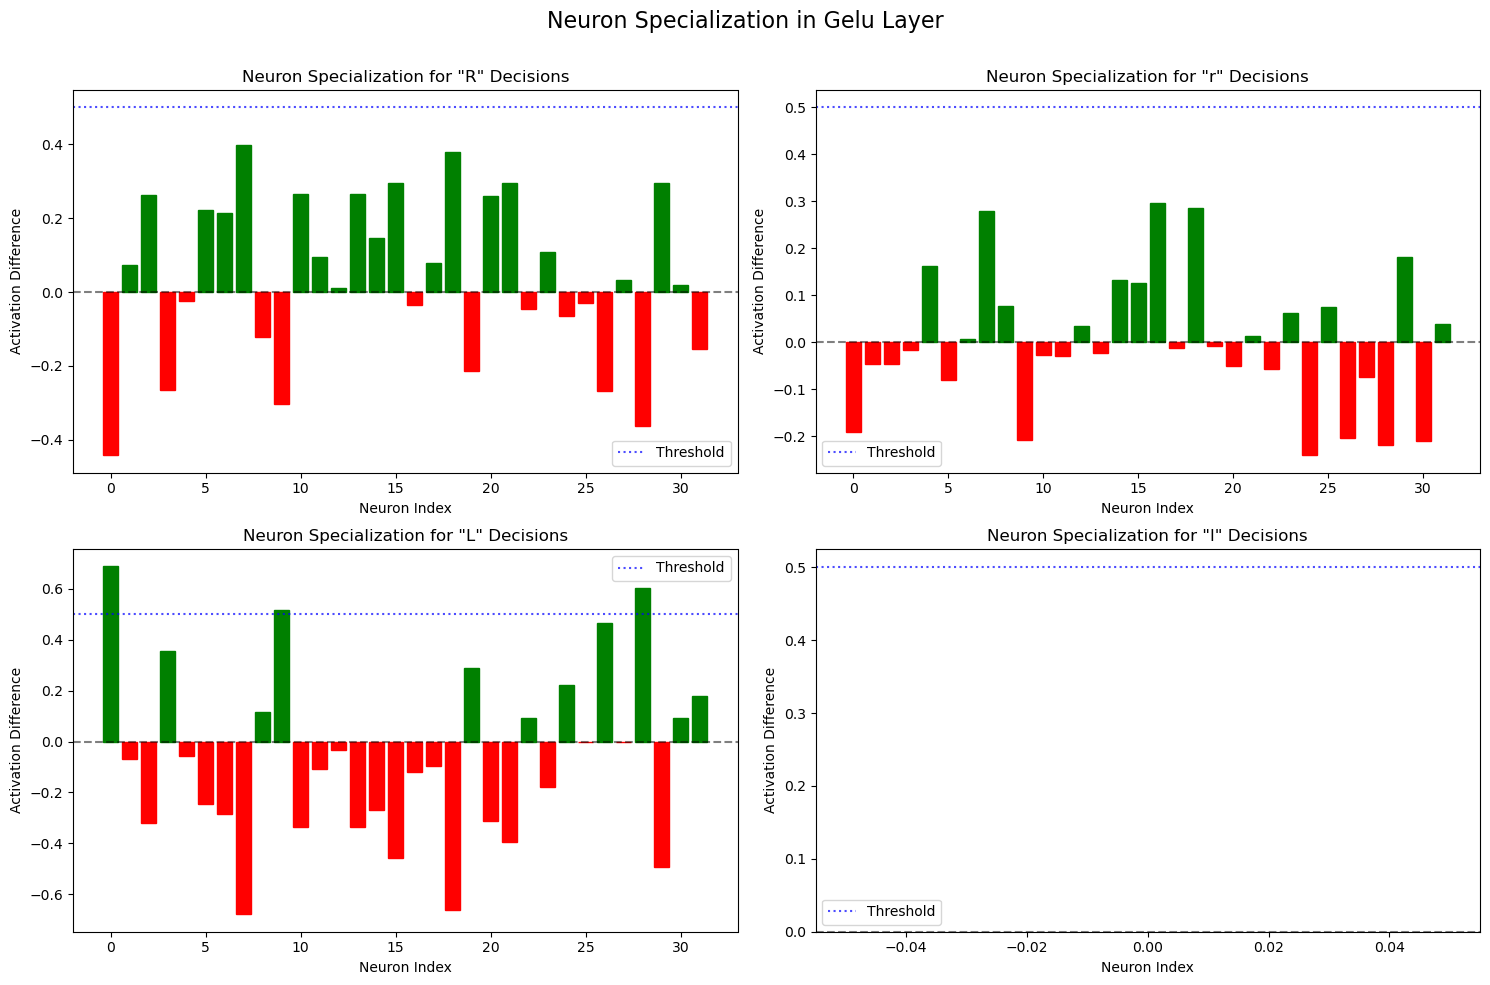

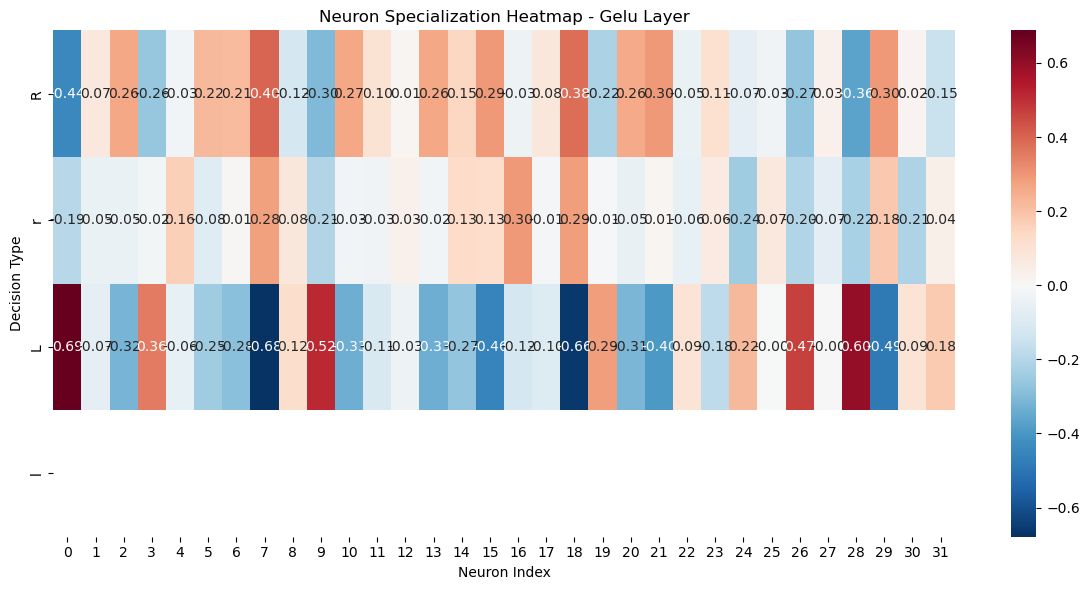

/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home10/ccheung/.conda/envs/transformers/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Layer: output
Neurons specialized for R decisions: []
Neurons specialized for r decisions: []
Neurons specialized for L decisions: [1]
Neurons specialized for l decisions: []


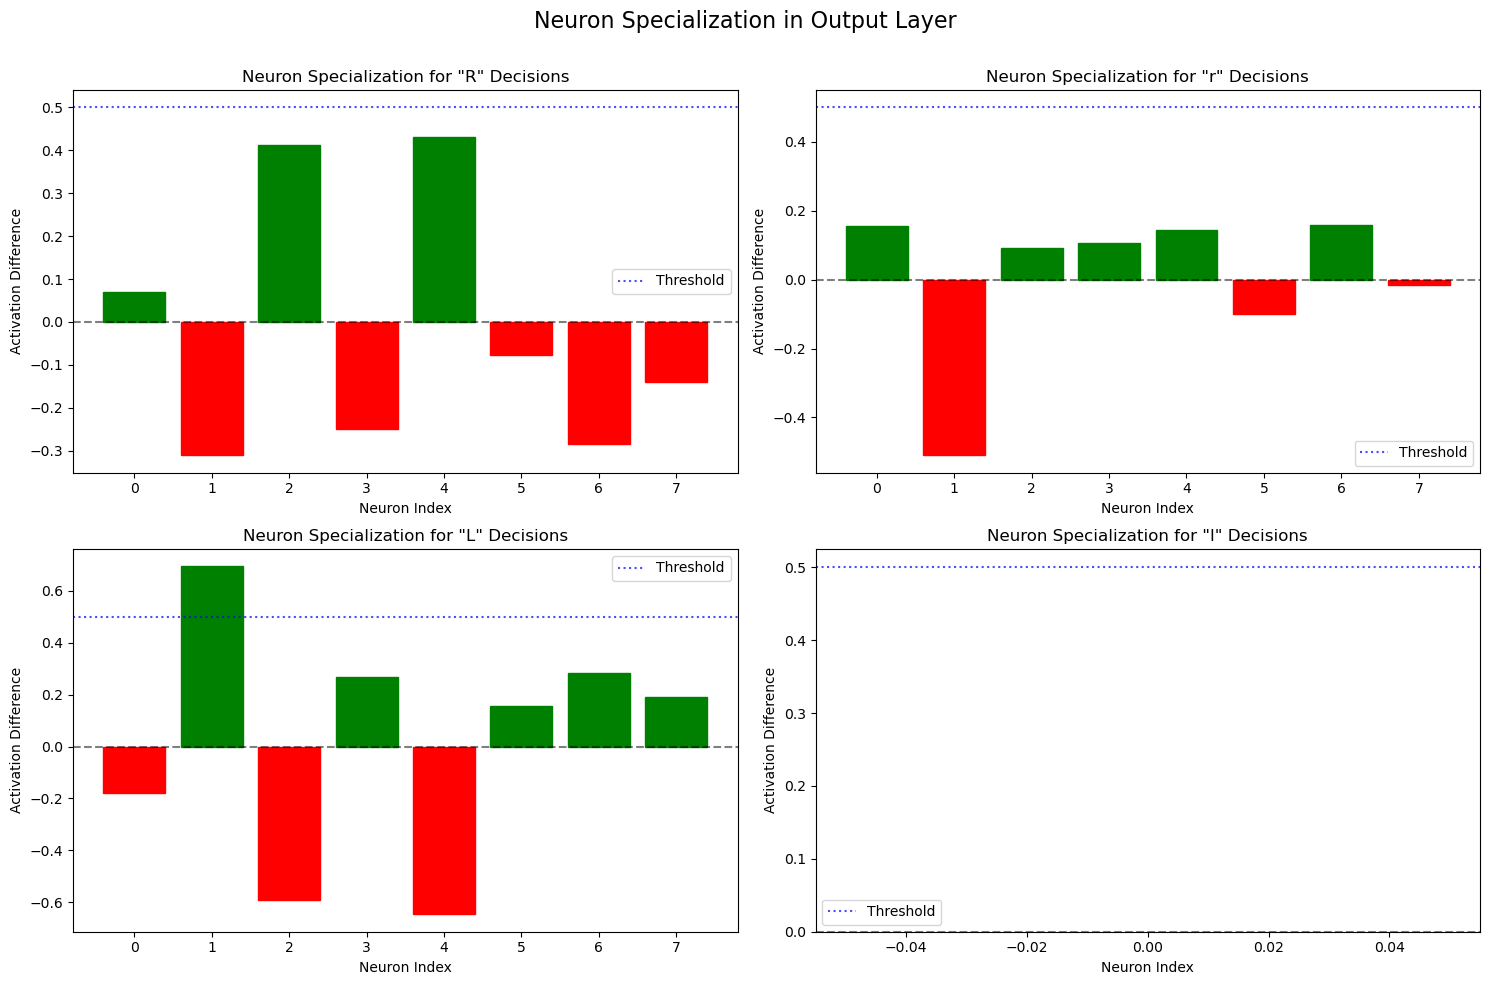

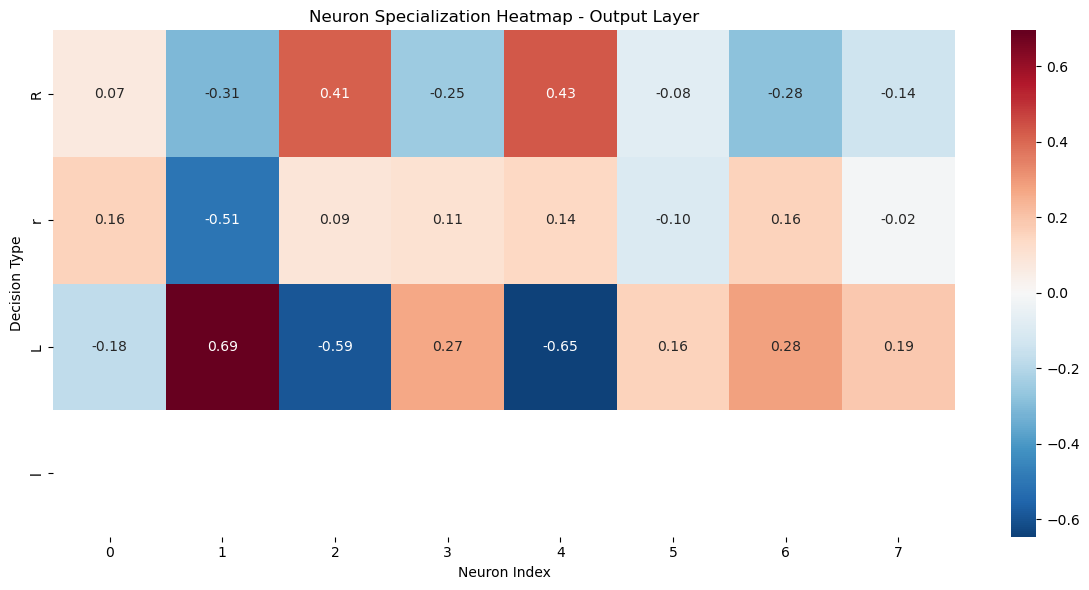

In [8]:
# Modify get_mlp_activations to capture different MLP layers
def get_mlp_detailed_activations(model, input_seq, vocab, stoi):
    """Extract activations from different layers of the MLP"""
    # Convert sequence to tensor
    indices = [stoi[c] for c in input_seq]
    tokens = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # Storage for activations from different MLP layers
    mlp_layers = {
        'input': [],     # Input to MLP
        'hidden': [],    # After first linear layer (c_fc)
        'gelu': [],      # After GELU activation 
        'output': []     # After projection layer (c_proj)
    }
    
    # Register hooks for each layer
    def input_hook(module, input, output):
        mlp_layers['input'].append(input[0].detach().cpu().numpy())
    
    def hidden_hook(module, input, output):
        mlp_layers['hidden'].append(output.detach().cpu().numpy())
    
    def gelu_hook(module, input, output):
        mlp_layers['gelu'].append(output.detach().cpu().numpy())
    
    def output_hook(module, input, output):
        mlp_layers['output'].append(output.detach().cpu().numpy())
    
    # Register hooks on each part of the MLP
    hooks = []
    for block in model.transformer.h:
        # Hook before MLP (input to MLP)
        handle = block.ln_2.register_forward_hook(input_hook)
        hooks.append(handle)
        
        # Hook after first linear layer
        handle = block.mlp.c_fc.register_forward_hook(hidden_hook)
        hooks.append(handle)
        
        # Hook after GELU activation
        handle = block.mlp.gelu.register_forward_hook(gelu_hook)
        hooks.append(handle)
        
        # Hook after projection layer
        handle = block.mlp.c_proj.register_forward_hook(output_hook)
        hooks.append(handle)
    
    # Forward pass
    with torch.no_grad():
        model(tokens)
    
    # Remove hooks
    for handle in hooks:
        handle.remove()
    
    return mlp_layers

# Collect detailed MLP activations for each sequence
detailed_activations = {}
for seq in sequences:
    detailed_activations[seq] = get_mlp_detailed_activations(model, seq, vocab, stoi)

# Extract last position activations for each layer
last_pos_by_layer = {
    layer_name: {
        seq: detailed_activations[seq][layer_name][0][0, -1, :] 
        for seq in sequences
    }
    for layer_name in ['input', 'hidden', 'gelu', 'output']
}

# Function to analyze neuron specialization for a specific layer
def analyze_layer_specialization(layer_name):
    # Get activations for this layer
    layer_activations = last_pos_by_layer[layer_name]
    
    # Group sequences by their last token (decision)
    R_sequences = [seq for seq in sequences if seq[-1] == 'R']
    r_sequences = [seq for seq in sequences if seq[-1] == 'r']
    L_sequences = [seq for seq in sequences if seq[-1] == 'L']
    l_sequences = [seq for seq in sequences if seq[-1] == 'l']
    
    # Find specialized neurons for each decision type
    def find_decision_neurons(decision_seqs, other_seqs, threshold=0.5):
        # Average activation for decision sequences
        decision_act = np.mean([layer_activations[seq] for seq in decision_seqs], axis=0)
        # Average activation for other sequences
        other_act = np.mean([layer_activations[seq] for seq in other_seqs], axis=0)
        # Difference in activation
        diff = decision_act - other_act
        decision_neurons = np.where(diff > threshold)[0]
        return decision_neurons, diff
    
    # Find neurons specialized for each decision
    R_neurons, R_diff = find_decision_neurons(R_sequences, r_sequences + L_sequences + l_sequences)
    r_neurons, r_diff = find_decision_neurons(r_sequences, R_sequences + L_sequences + l_sequences)
    L_neurons, L_diff = find_decision_neurons(L_sequences, R_sequences + r_sequences + l_sequences)
    l_neurons, l_diff = find_decision_neurons(l_sequences, R_sequences + r_sequences + L_sequences)
    
    # Print specialized neurons
    print(f"\nLayer: {layer_name}")
    print(f"Neurons specialized for R decisions: {R_neurons}")
    print(f"Neurons specialized for r decisions: {r_neurons}")
    print(f"Neurons specialized for L decisions: {L_neurons}")
    print(f"Neurons specialized for l decisions: {l_neurons}")
    
    # Create visualization 
    plt.figure(figsize=(15, 10))
    
    # Plot for each decision type
    decisions = ['R', 'r', 'L', 'l']
    diffs = [R_diff, r_diff, L_diff, l_diff]
    
    for i, (decision, diff) in enumerate(zip(decisions, diffs)):
        plt.subplot(2, 2, i+1)
        bars = plt.bar(range(len(diff)), diff)
        
        # Color positive bars green and negative bars red
        for j, bar in enumerate(bars):
            if diff[j] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
        
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.title(f'Neuron Specialization for "{decision}" Decisions')
        plt.xlabel('Neuron Index')
        plt.ylabel('Activation Difference')
        
        # Add threshold line
        plt.axhline(y=0.5, color='blue', linestyle=':', alpha=0.7, label='Threshold')
        plt.legend()
    
    plt.suptitle(f'Neuron Specialization in {layer_name.capitalize()} Layer', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Create heatmap visualization of all differences
    plt.figure(figsize=(12, 6))
    diff_data = np.vstack([R_diff, r_diff, L_diff, l_diff])
    sns.heatmap(diff_data, cmap="RdBu_r", center=0, annot=True, fmt=".2f",
                xticklabels=range(diff_data.shape[1]), 
                yticklabels=decisions)
    plt.title(f'Neuron Specialization Heatmap - {layer_name.capitalize()} Layer')
    plt.xlabel('Neuron Index')
    plt.ylabel('Decision Type')
    plt.tight_layout()
    plt.show()

# Analyze specialization in each layer
for layer_name in ['input', 'hidden', 'gelu', 'output']:
    analyze_layer_specialization(layer_name)

In [9]:
print(detailed_activations['RRRRRR']['hidden'])
print(type(detailed_activations['RRRRRR']))
if isinstance(detailed_activations['RRRRRR'], dict):
    print(detailed_activations['RRRRRR'].keys())

[array([[[-0.5799393 ,  0.14797759,  0.39986944, -0.2654535 ,
          0.11641695,  0.23067313,  0.24063194,  0.7502088 ,
         -0.0219316 , -0.503082  ,  0.5296053 , -0.10260265,
          0.09172659,  0.44310027,  0.26368633,  0.5302438 ,
          0.07906265, -0.01192263,  0.7582601 , -0.23755614,
          0.43182108,  0.558341  , -0.03349992,  0.06996341,
         -0.5280661 ,  0.05294131, -0.4325356 , -0.21230951,
         -0.49424803,  0.5605351 , -0.19196588, -0.00499053],
        [-0.63612825,  0.10592202,  0.40734783, -0.2895758 ,
          0.1289806 ,  0.25443196,  0.28572193,  0.7965473 ,
         -0.0382178 , -0.46088073,  0.50426215,  0.0008875 ,
          0.07680566,  0.4482144 ,  0.2777128 ,  0.517056  ,
          0.13903551,  0.04466671,  0.7696728 , -0.2537302 ,
          0.42970592,  0.55261177, -0.08469705,  0.14266303,
         -0.39812905,  0.06341015, -0.43381026, -0.11843073,
         -0.47713965,  0.59163356, -0.14982647, -0.05201408],
        [-0.6215317 ,

# 5. Cluster Sequences by Activation Patterns

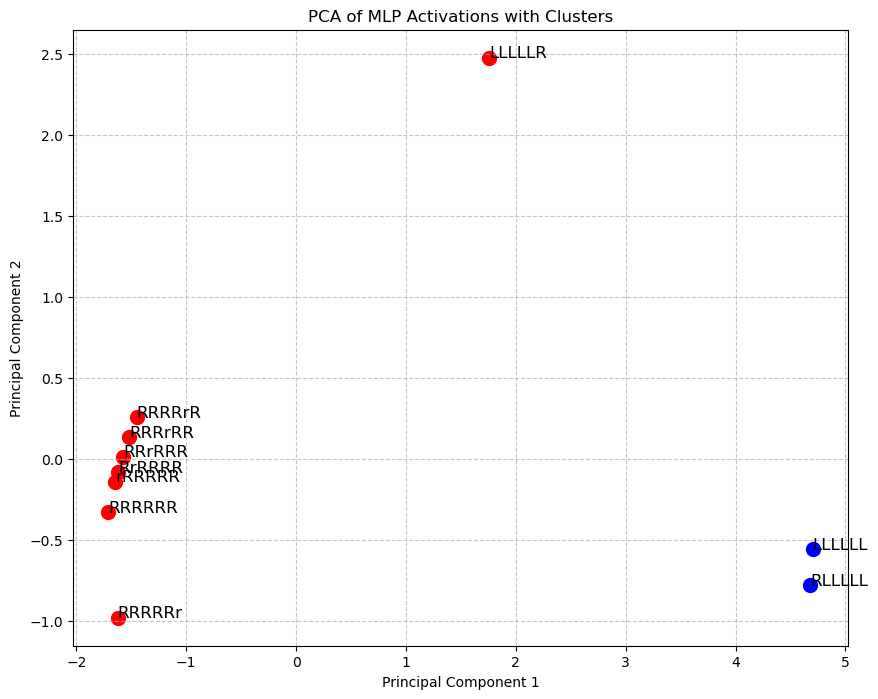

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Convert activations to a format suitable for clustering
X = np.array([last_pos_activations[seq] for seq in sequences])

# Use PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, seq in enumerate(sequences):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], 
                color=['red' if seq[-1] in ('R', 'r') else 'blue' for seq in sequences][i],
                s=100)
    plt.annotate(seq, (X_pca[i, 0], X_pca[i, 1]), fontsize=12)

plt.title('PCA of MLP Activations with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 6. Correlation Matrix between Neurons

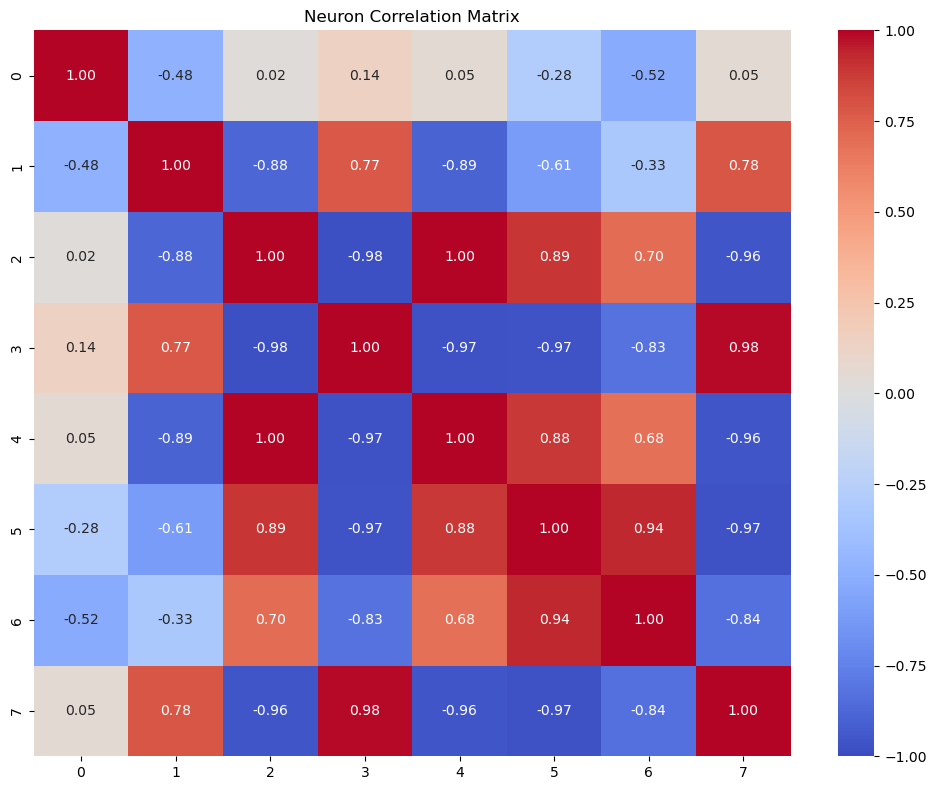

In [11]:
# Calculate correlation between neurons (input layer)
neuron_corr = activation_df.T.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(neuron_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Neuron Correlation Matrix")
plt.tight_layout()
plt.show()

# 7. Probing to find maximal activation across layers

In [12]:
sequences = vc[vc > 50].index.tolist()[:1000]

detailed_activations = {}
for seq in sequences:
    detailed_activations[seq] = get_mlp_detailed_activations(model, seq, vocab, stoi)
last_pos_by_layer = {
    layer_name: {
        seq: detailed_activations[seq][layer_name][0][0, -1, :] 
        for seq in sequences
    }
    for layer_name in ['input', 'hidden', 'gelu', 'output']
}

In [13]:
def find_maximal_activations(layer_name, top_n=3):
    """Find which input sequences maximally activate each neuron in a specified MLP layer"""
    layer_activations = last_pos_by_layer[layer_name]
    
    # Number of neurons in this layer
    if layer_name in ['input', 'output']:
        num_neurons = config.n_embd  # Input/output dimension is embedding size
    else:  # hidden or gelu
        num_neurons = 4 * config.n_embd  # Hidden dimension is 4x embedding size
    
    # Store max activating sequences for each neuron
    max_activating_seqs = {}
    
    for neuron_idx in range(num_neurons):
        # Get activation of this neuron for each sequence
        neuron_activations = {seq: layer_activations[seq][neuron_idx] for seq in sequences}
        
        # Sort sequences by neuron activation (highest first)
        sorted_seqs = sorted(neuron_activations.items(), key=lambda x: x[1], reverse=True)
        
        # Store top N most activating sequences
        max_activating_seqs[neuron_idx] = sorted_seqs[:top_n]
    
    return max_activating_seqs

# Find maximal activations for each layer
max_activations = {}
for layer_name in ['input', 'hidden', 'gelu', 'output']:
    max_activations[layer_name] = find_maximal_activations(layer_name)
    
    # Print example results for a few neurons
    print(f"\n{layer_name.upper()} LAYER - Top activating sequences:")
    for neuron_idx in range(min(5, len(max_activations[layer_name]))):  # Show first 5 neurons
        print(f"Neuron {neuron_idx}: ", end="")
        for seq, act in max_activations[layer_name][neuron_idx]:
            print(f"{seq} ({act:.3f})", end=" | ")
        print()


INPUT LAYER - Top activating sequences:
Neuron 0: lllllR (0.387) | LllllR (0.386) | lLlllR (0.385) | 
Neuron 1: RRRRRR (0.253) | RRRlRR (0.249) | RRlRRR (0.248) | 
Neuron 2: LLLLLL (0.556) | rLLLLL (0.545) | LrLLLL (0.538) | 
Neuron 3: RRRRRR (0.482) | rRRRRR (0.463) | RlRRRR (0.460) | 
Neuron 4: rLLLLL (0.360) | rrLLLL (0.359) | LLLLLL (0.358) | 

HIDDEN LAYER - Top activating sequences:
Neuron 0: LLLLLL (0.723) | rLLLLL (0.723) | LrLLLL (0.722) | 
Neuron 1: LLLllR (0.175) | LlLllR (0.174) | LLlllR (0.173) | 
Neuron 2: LLLllR (0.505) | LlLllR (0.505) | lllLlR (0.502) | 
Neuron 3: RRRrrL (0.559) | RRRRrL (0.553) | RRrrrL (0.533) | 
Neuron 4: RRRRrL (0.416) | RRRRRl (0.384) | RRRrRl (0.362) | 

GELU LAYER - Top activating sequences:
Neuron 0: LLLLLL (0.553) | rLLLLL (0.553) | LrLLLL (0.552) | 
Neuron 1: LLLllR (0.099) | LlLllR (0.099) | LLlllR (0.098) | 
Neuron 2: LLLllR (0.350) | LlLllR (0.350) | lllLlR (0.348) | 
Neuron 3: RRRrrL (0.398) | RRRRrL (0.392) | RRrrrL (0.374) | 
Neuron 4:

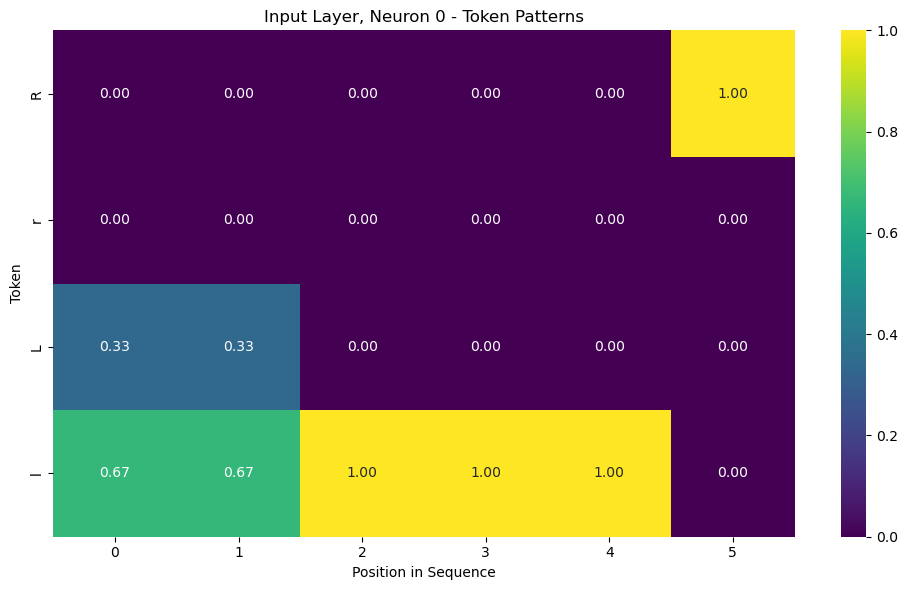


Patterns detected by input layer, Neuron 0:
Position 2: Strong preference for 'l'
Position 3: Strong preference for 'l'
Position 4: Strong preference for 'l'
Position 5: Strong preference for 'R'


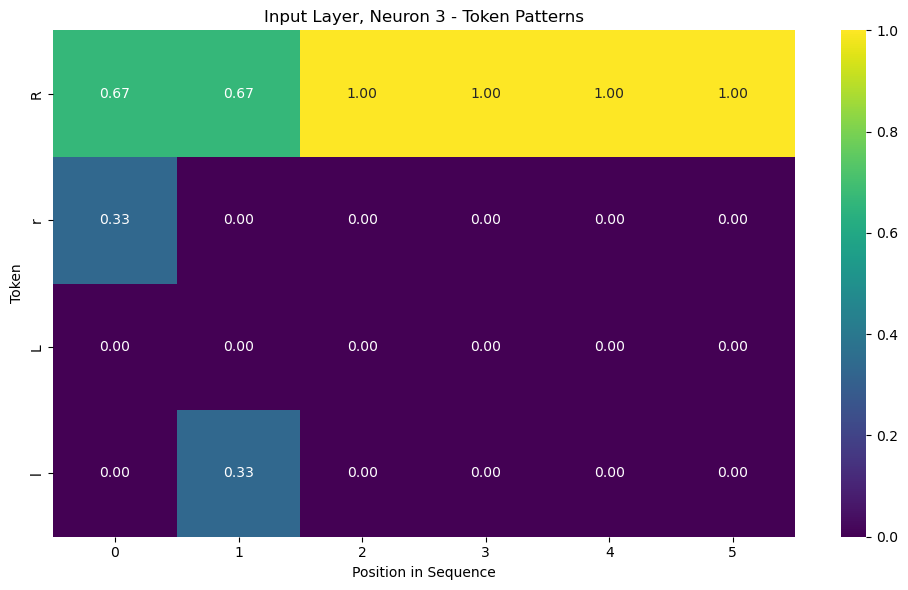


Patterns detected by input layer, Neuron 3:
Position 2: Strong preference for 'R'
Position 3: Strong preference for 'R'
Position 4: Strong preference for 'R'
Position 5: Strong preference for 'R'


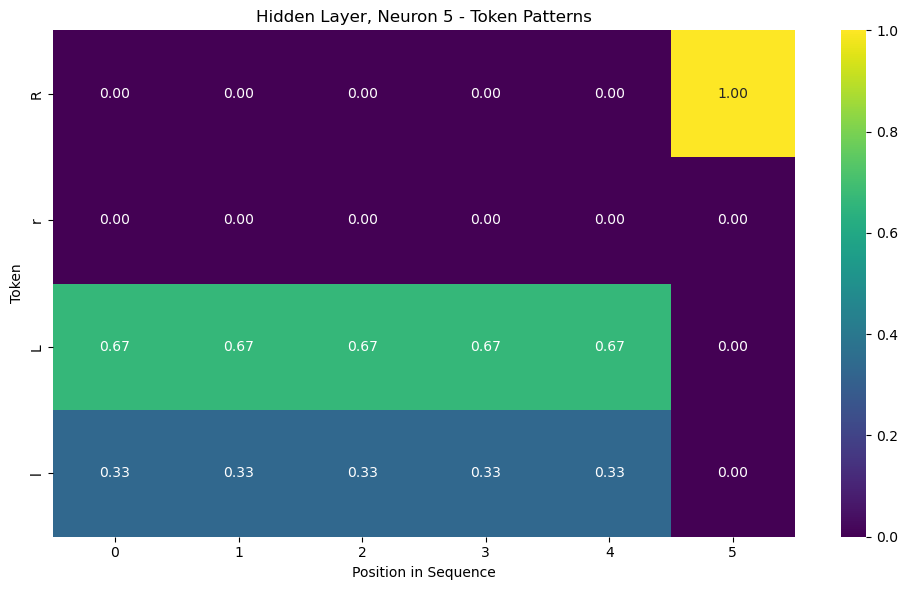


Patterns detected by hidden layer, Neuron 5:
Position 5: Strong preference for 'R'
→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)
→ This neuron may be detecting repeated tokens of the same type


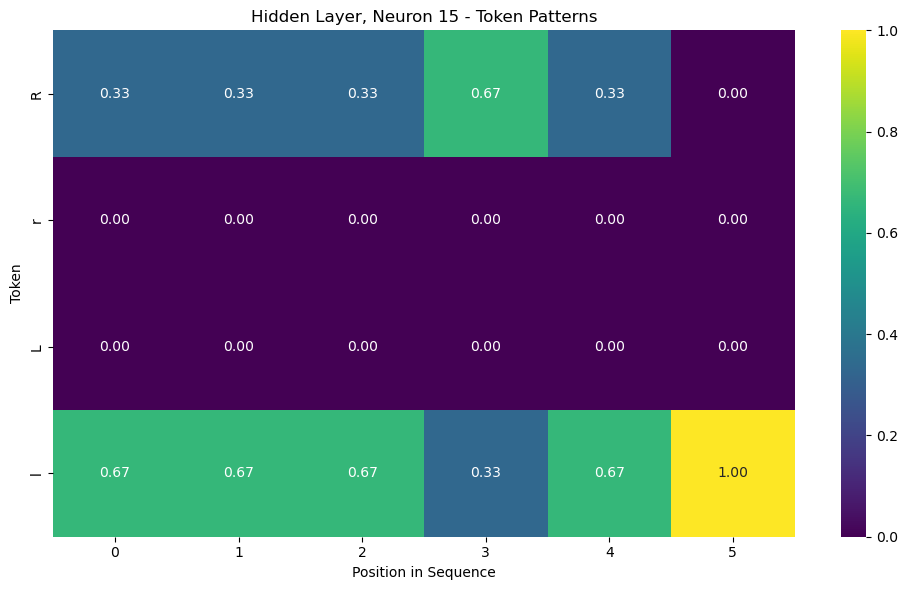


Patterns detected by hidden layer, Neuron 15:
Position 5: Strong preference for 'l'
→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)


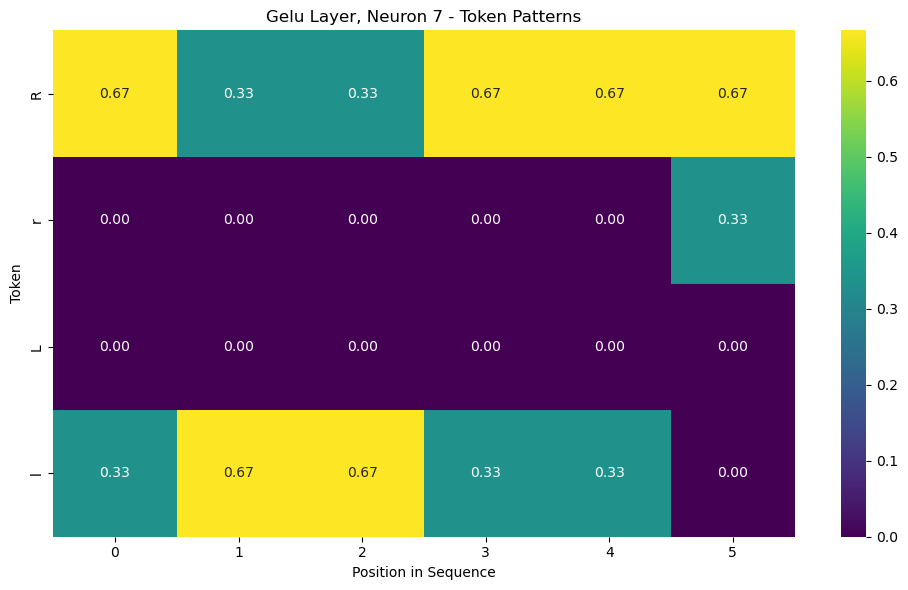


Patterns detected by gelu layer, Neuron 7:
→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)
→ This neuron may be detecting repeated tokens of the same type


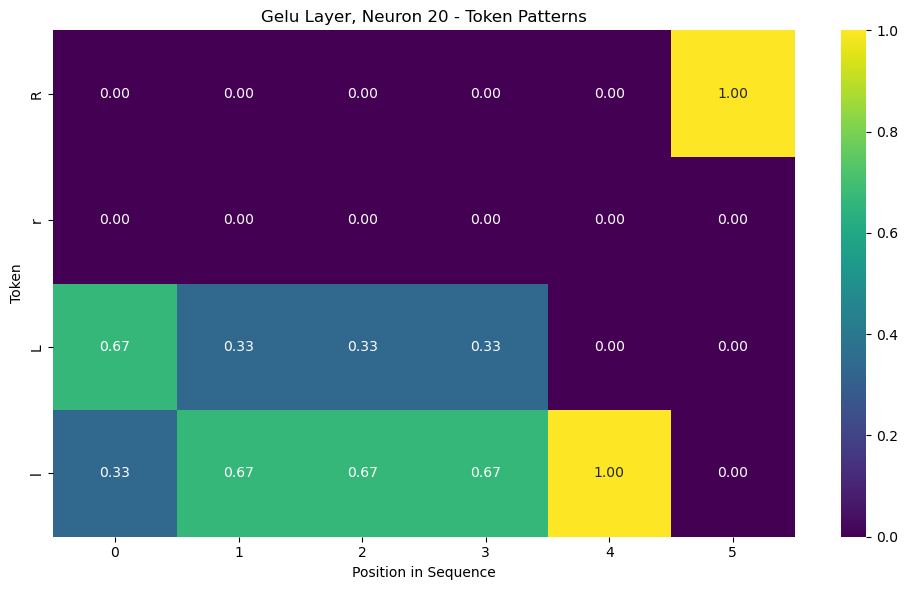


Patterns detected by gelu layer, Neuron 20:
Position 4: Strong preference for 'l'
Position 5: Strong preference for 'R'
→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)


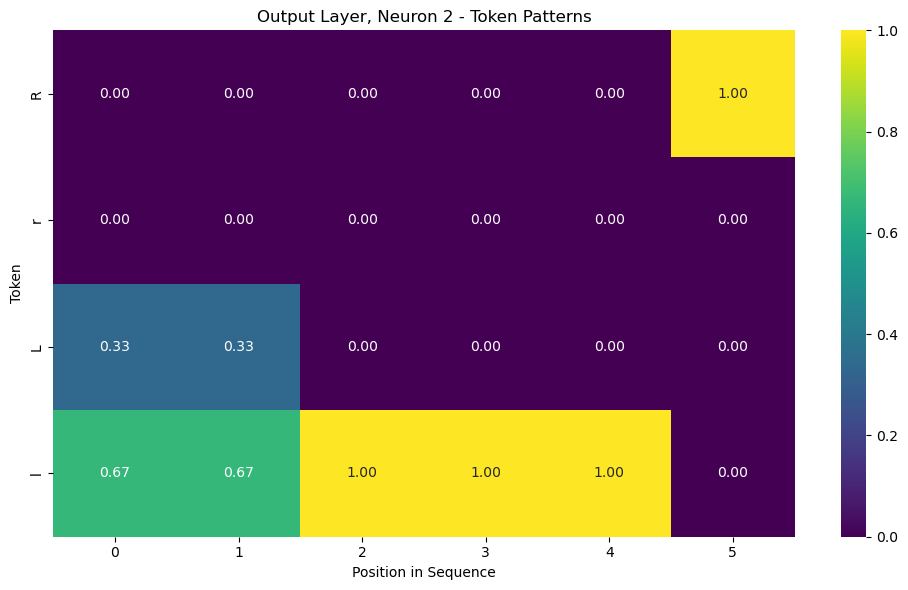


Patterns detected by output layer, Neuron 2:
Position 2: Strong preference for 'l'
Position 3: Strong preference for 'l'
Position 4: Strong preference for 'l'
Position 5: Strong preference for 'R'
→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)


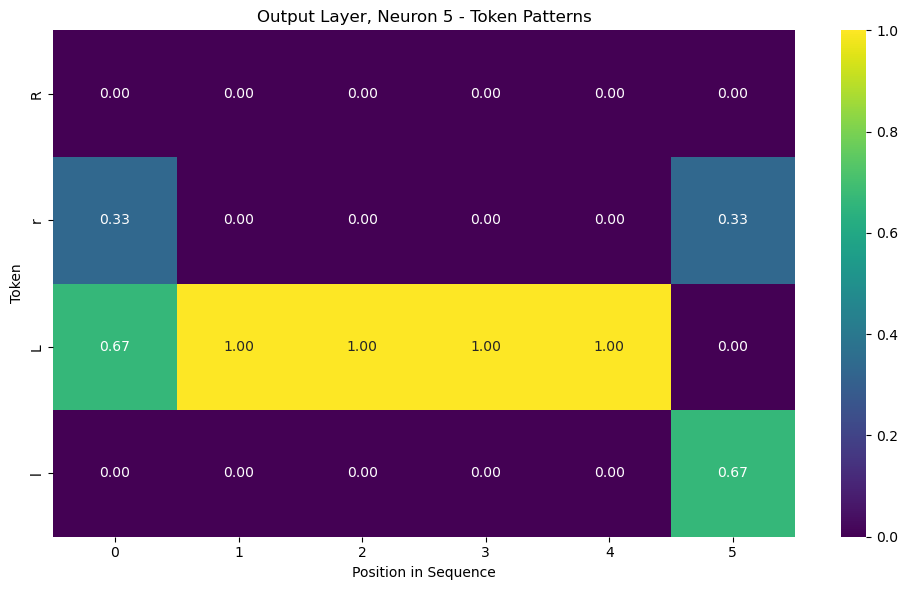


Patterns detected by output layer, Neuron 5:
Position 1: Strong preference for 'L'
Position 2: Strong preference for 'L'
Position 3: Strong preference for 'L'
Position 4: Strong preference for 'L'
→ This neuron may be detecting repeated tokens of the same type


In [14]:
def analyze_neuron_patterns(layer_name, neuron_idx):
    """Analyze patterns in sequences that maximally activate a specific neuron"""
    # Get sequences that maximally activate this neuron
    max_seqs = [seq for seq, _ in max_activations[layer_name][neuron_idx]]
    
    # Count token frequencies at each position across these sequences
    token_counts = []
    for pos in range(len(max_seqs[0])):  # Assuming all sequences have same length
        pos_counts = {'R': 0, 'r': 0, 'L': 0, 'l': 0}
        for seq in max_seqs:
            pos_counts[seq[pos]] += 1
        token_counts.append(pos_counts)
    
    # Convert to DataFrame for visualization
    token_df = pd.DataFrame(token_counts)
    
    # Normalize counts
    token_df = token_df.div(token_df.sum(axis=1), axis=0)
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(token_df.T, cmap='viridis', annot=True, fmt='.2f')
    plt.title(f'{layer_name.capitalize()} Layer, Neuron {neuron_idx} - Token Patterns')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Token')
    plt.tight_layout()
    plt.show()
    
    # Analyze if this neuron might be detecting specific patterns
    print(f"\nPatterns detected by {layer_name} layer, Neuron {neuron_idx}:")
    
    # Check for position-specific token preferences
    for pos in range(len(token_counts)):
        max_token = max(token_counts[pos], key=token_counts[pos].get)
        if token_counts[pos][max_token] >= len(max_seqs) * 0.7:  # If 70%+ sequences have same token
            print(f"Position {pos}: Strong preference for '{max_token}'")
    
    # Check for contextual patterns
    if layer_name in ['hidden', 'gelu', 'output']:
        # Check if neuron responds to recent history
        last_tokens = [seq[-1] for seq in max_seqs]
        if all(token in ['R', 'r'] for token in last_tokens) or all(token in ['L', 'l'] for token in last_tokens):
            print("→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)")
        
        # Check for alternating patterns
        alternating_count = sum(1 for seq in max_seqs if 'RL' in seq or 'LR' in seq)
        if alternating_count >= len(max_seqs) * 0.7:
            print("→ This neuron may be detecting alternating patterns between R and L")
        
        # Check for repeated patterns
        repeat_count = sum(1 for seq in max_seqs if 'RR' in seq or 'LL' in seq)
        if repeat_count >= len(max_seqs) * 0.7:
            print("→ This neuron may be detecting repeated tokens of the same type")

# Analyze a few interesting neurons from each layer
interesting_neurons = {
    'input': [0, 3],      # Choose a couple of potentially interesting neurons
    'hidden': [5, 15],    # For hidden layers, choose neurons that might be capturing patterns
    'gelu': [7, 20],      # Some neurons after activation function
    'output': [2, 5]      # Output layer neurons
}

for layer_name, neurons in interesting_neurons.items():
    for neuron_idx in neurons:
        if neuron_idx < len(max_activations[layer_name]):
            analyze_neuron_patterns(layer_name, neuron_idx)

# 8. Probing by Generating Synthetic Inputs


Generating maximal input for input layer, neuron 2...


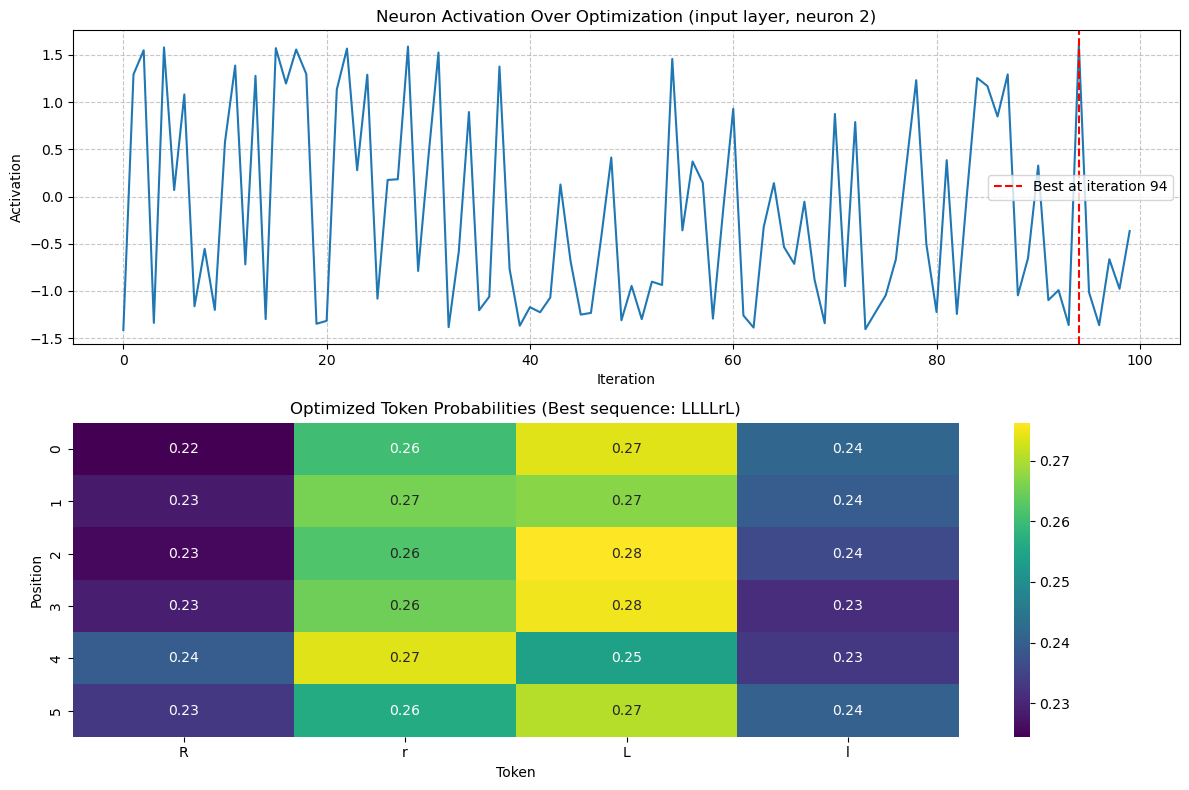

Best sequence: LLLLrL
Best iteration: 94
Best activation: 1.6095

Generating maximal input for hidden layer, neuron 5...


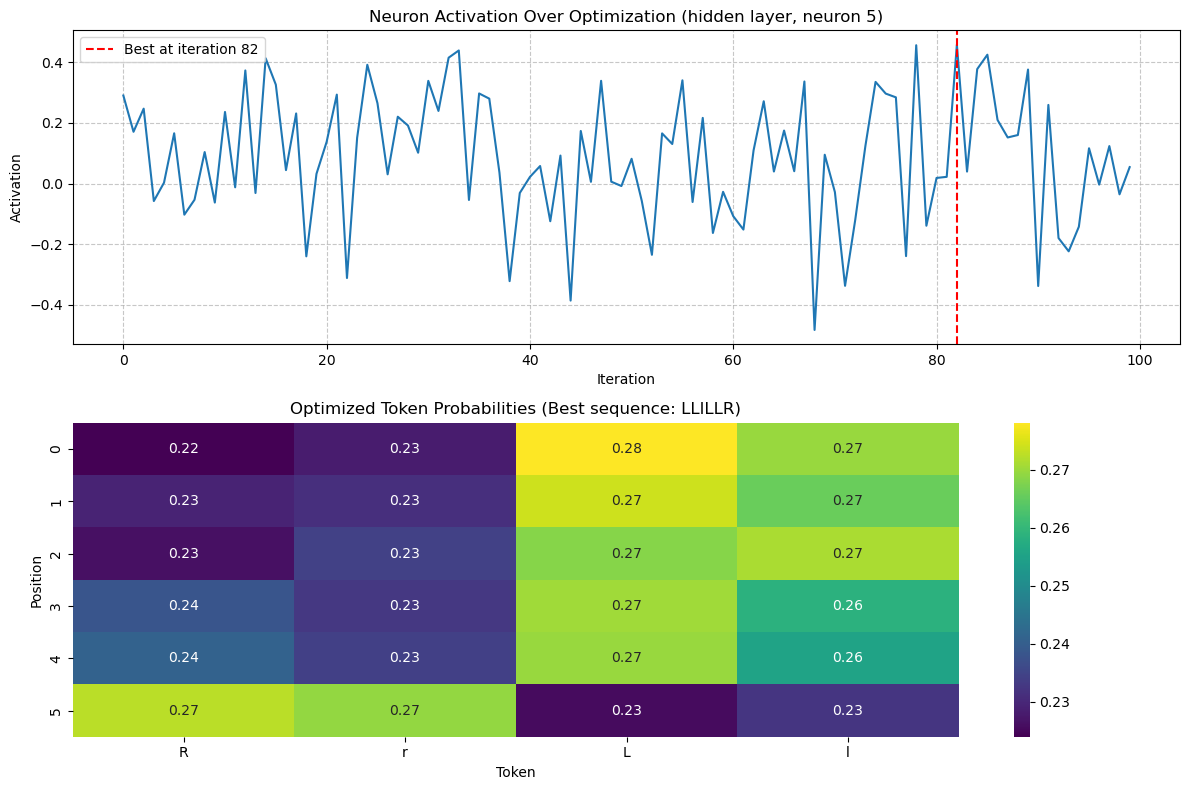

Best sequence: LLlLLR
Best iteration: 82
Best activation: 0.4585

Generating maximal input for gelu layer, neuron 2...


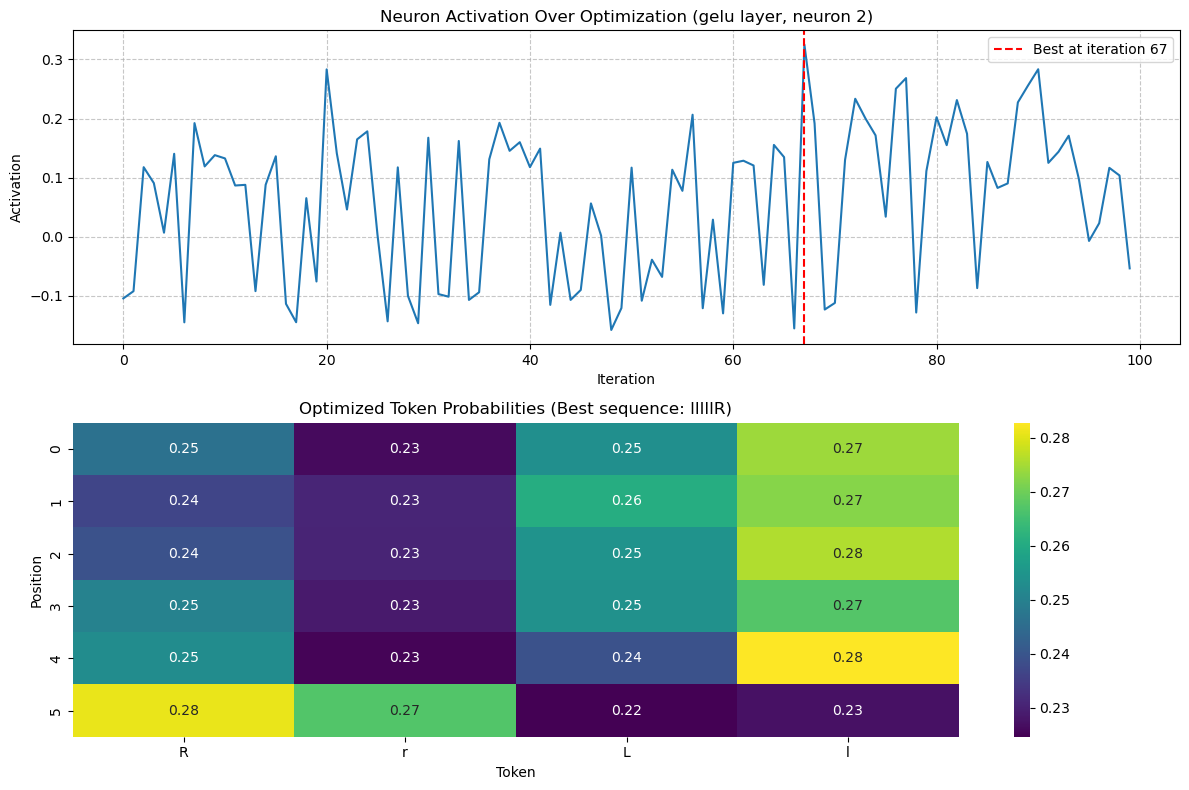

Best sequence: lllllR
Best iteration: 67
Best activation: 0.3250

Generating maximal input for output layer, neuron 2...


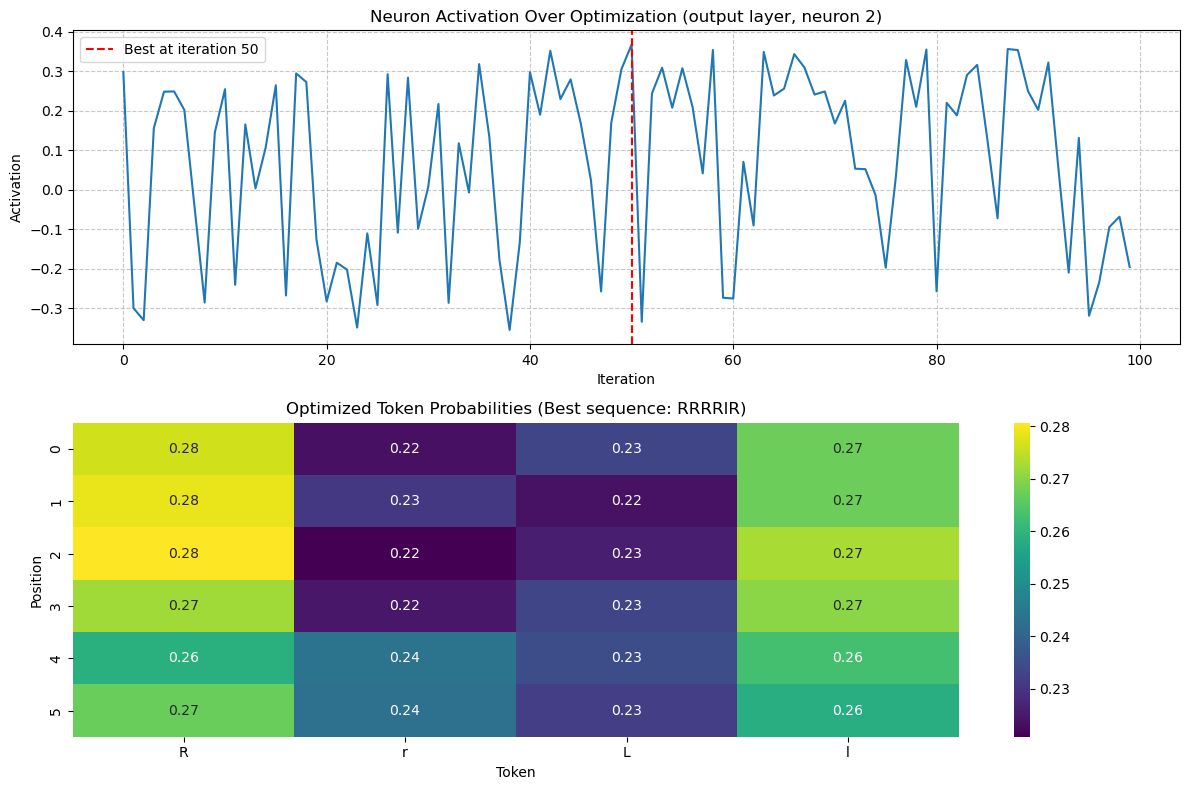

Best sequence: RRRRlR
Best iteration: 50
Best activation: 0.3676


In [21]:
def generate_maximal_input(layer_name, neuron_idx, iterations=100, lr=0.1):
    """Generate a synthetic input that maximally activates a specific neuron"""
    # Create a soft representation of a sequence (probabilities over vocabulary)
    sequence_length = 6  # Same as our training sequences
    
    # Initialize with uniform probabilities - properly create a leaf tensor
    token_probs = torch.ones((sequence_length, len(vocab)), device=device) / len(vocab)
    token_probs = token_probs.clone().detach().requires_grad_(True)  # Make it a proper leaf tensor
    
    # Create optimizer
    optimizer = torch.optim.Adam([token_probs], lr=lr)
    
    # Optimization loop
    activation_history = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        
        # Generate a soft one-hot encoding of the sequence
        soft_tokens = F.gumbel_softmax(token_probs, tau=1.0, hard=False, dim=-1)
        
        # Create embeddings from soft tokens - fix the matrix multiplication
        # Get embedding dimension
        embed_dim = model.transformer.wte.weight.shape[1]
        
        # Initialize an empty tensor for the embeddings
        token_embeds = torch.zeros((sequence_length, embed_dim), device=device)
        
        # For each position, compute the weighted sum of embeddings
        for pos in range(sequence_length):
            for token_idx in range(len(vocab)):
                token_embeds[pos] += soft_tokens[pos, token_idx] * model.transformer.wte.weight[token_idx]
        
        # Add position embeddings
        pos = torch.arange(0, sequence_length, dtype=torch.long, device=device)
        pos_embeds = model.transformer.wpe(pos)
        x = token_embeds + pos_embeds
        
        # Add batch dimension
        x = x.unsqueeze(0)
        
        # Forward through the model layers until the target layer
        if layer_name == 'input':
            # Input to MLP is after attention and layer norm
            for block in model.transformer.h:
                ln_1_out = block.ln_1(x)
                attn_out = block.attn(ln_1_out)
                x = x + attn_out
                target_activation = block.ln_2(x)[0, -1, neuron_idx]
                break
                
        elif layer_name == 'hidden':
            # Hidden layer is after first linear layer in MLP
            for block in model.transformer.h:
                ln_1_out = block.ln_1(x)
                attn_out = block.attn(ln_1_out)
                x = x + attn_out
                ln_2_out = block.ln_2(x)
                target_activation = block.mlp.c_fc(ln_2_out)[0, -1, neuron_idx]
                break
                
        elif layer_name == 'gelu':
            # After GELU activation
            for block in model.transformer.h:
                ln_1_out = block.ln_1(x)
                attn_out = block.attn(ln_1_out)
                x = x + attn_out
                ln_2_out = block.ln_2(x)
                fc_out = block.mlp.c_fc(ln_2_out)
                target_activation = block.mlp.gelu(fc_out)[0, -1, neuron_idx]
                break
                
        elif layer_name == 'output':
            # Output of MLP
            for block in model.transformer.h:
                ln_1_out = block.ln_1(x)
                attn_out = block.attn(ln_1_out)
                x = x + attn_out
                ln_2_out = block.ln_2(x)
                mlp_out = block.mlp(ln_2_out)
                target_activation = mlp_out[0, -1, neuron_idx]
                break
        
        # Maximize the target activation
        loss = -target_activation
        loss.backward()
        optimizer.step()
        
        # Record activation value
        activation_history.append(target_activation.item())
        
        # Ensure probabilities sum to 1
        with torch.no_grad():
            token_probs.data = F.softmax(token_probs.data, dim=-1)
    
    # Convert soft tokens to most likely sequence
    with torch.no_grad():
        best_tokens = torch.argmax(token_probs, dim=-1).cpu().numpy()
    best_sequence = ''.join([vocab[idx] for idx in best_tokens])
    
    # Find the iteration with the highest activation
    best_iteration = np.argmax(activation_history)
    best_activation = activation_history[best_iteration]
    
    # Visualize token probabilities for the optimized sequence
    token_probs_np = token_probs.detach().cpu().numpy()
    
    plt.figure(figsize=(12, 8))
    
    # Plot final activation achieved
    plt.subplot(2, 1, 1)
    plt.plot(activation_history)
    plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best at iteration {best_iteration}')
    plt.title(f'Neuron Activation Over Optimization ({layer_name} layer, neuron {neuron_idx})')
    plt.xlabel('Iteration')
    plt.ylabel('Activation')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot token probabilities for each position
    plt.subplot(2, 1, 2)
    sns.heatmap(token_probs_np, annot=True, fmt='.2f', cmap='viridis',
                xticklabels=vocab, yticklabels=range(sequence_length))
    plt.title(f'Optimized Token Probabilities (Best sequence: {best_sequence})')
    plt.xlabel('Token')
    plt.ylabel('Position')
    
    plt.tight_layout()
    plt.show()
    
    return best_sequence, token_probs_np, activation_history, best_iteration, best_activation

# Choose specific neurons to probe from different layers
for layer_name in ['input', 'hidden', 'gelu', 'output']:
    # Since max_activations may not be available, choose a fixed neuron index
    # For hidden layer (dimension 32), try neuron 5
    # For output layer (dimension 8), try neuron 2
    if layer_name == 'hidden':
        neuron_idx = 5  # Or any index < 32 (hidden dimension)
    else:  # 'output'
        neuron_idx = 2  # Or any index < 8 (output dimension)
    
    print(f"\nGenerating maximal input for {layer_name} layer, neuron {neuron_idx}...")
    best_seq, probs, history, best_iter, best_act = generate_maximal_input(layer_name, neuron_idx)
    print(f"Best sequence: {best_seq}")
    print(f"Best iteration: {best_iter}")
    print(f"Best activation: {best_act:.4f}")

# 9. MLP Layer Interp

In [16]:
sequences = vc[vc > 50].index.tolist()[:50]

detailed_activations = {}
for seq in sequences:
    detailed_activations[seq] = get_mlp_detailed_activations(model, seq, vocab, stoi)
last_pos_by_layer = {
    layer_name: {
        seq: detailed_activations[seq][layer_name][0][0, -1, :] 
        for seq in sequences
    }
    for layer_name in ['input', 'hidden', 'gelu', 'output']
}

Note: hidden and input have different dimensions, using PCA for comparison
Note: hidden and output have different dimensions, using PCA for comparison
Note: gelu and input have different dimensions, using PCA for comparison
Note: gelu and output have different dimensions, using PCA for comparison

Correlations between layer representations:
input-output: -0.6745
hidden-input: -0.9412
hidden-output: 0.7911
gelu-input: 0.8703
gelu-hidden: 0.9659
gelu-output: -0.7484


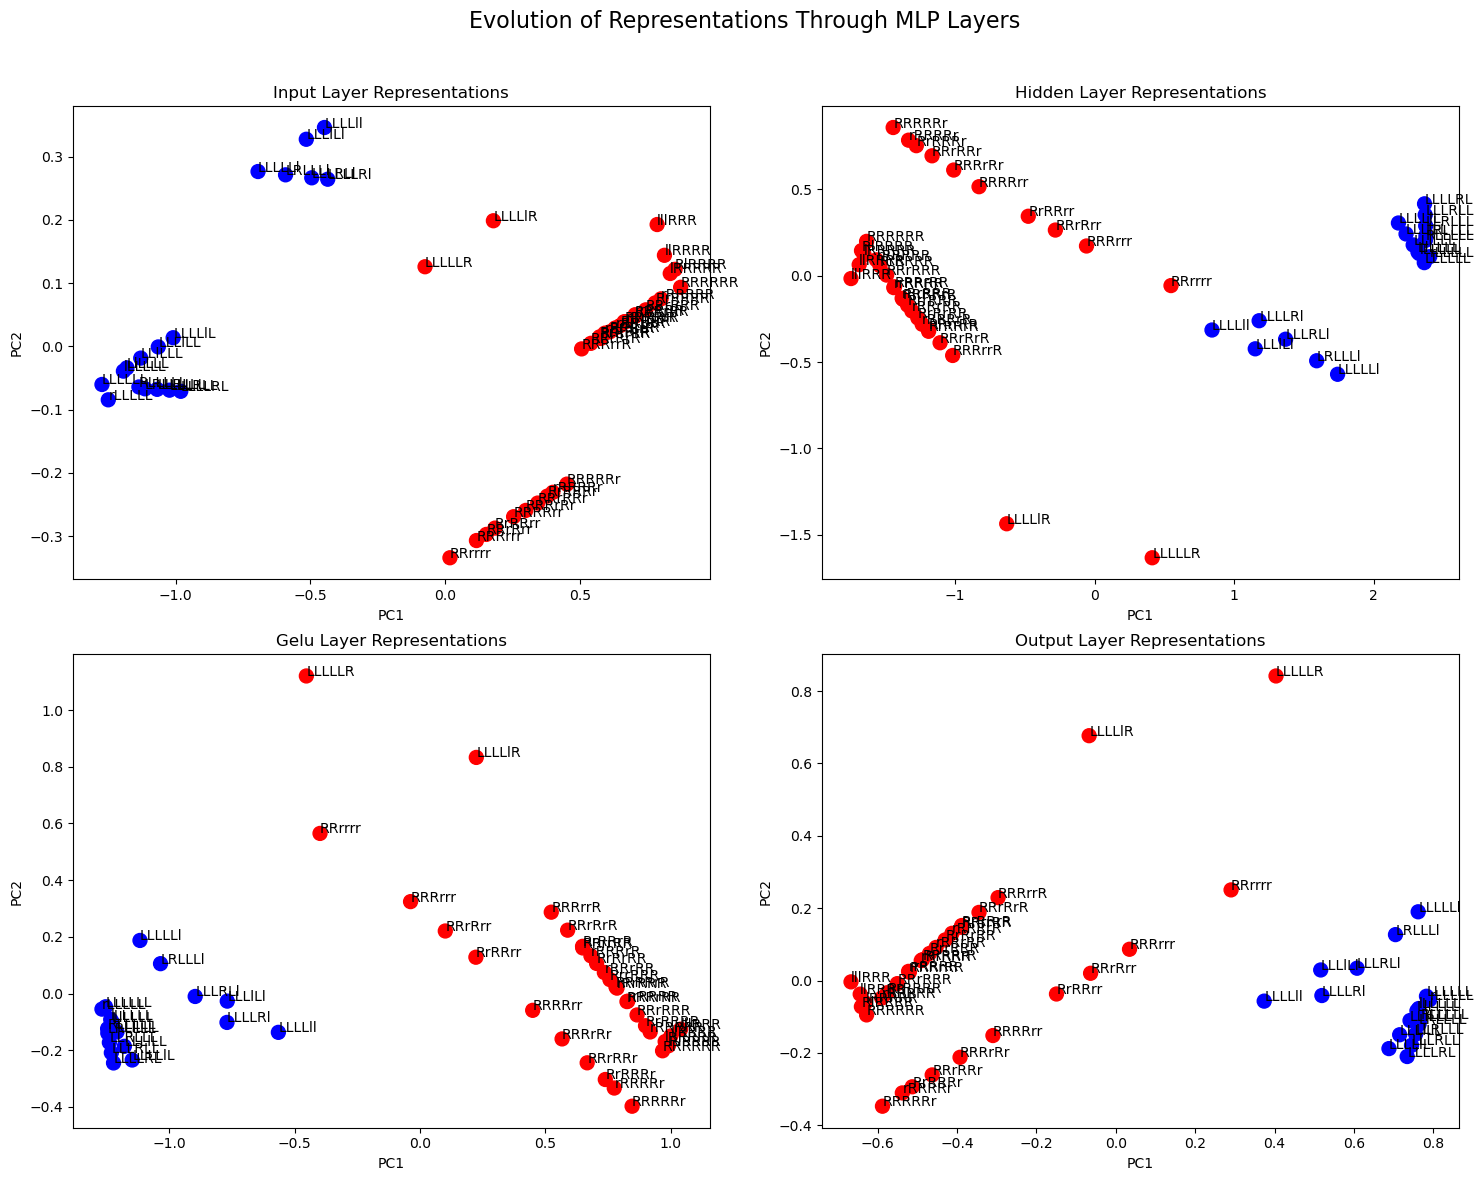

In [20]:

def compare_layer_representations():
    """Compare how representations evolve through the MLP layers"""
    # Get activations from all layers
    all_activations = {}
    
    for layer_name in ['input', 'hidden', 'gelu', 'output']:
        # Reshape data to be (n_sequences, n_neurons)
        layer_acts = np.array([last_pos_by_layer[layer_name][seq] for seq in sequences])
        all_activations[layer_name] = layer_acts
    
    # Compute pairwise correlations between neuron activations in different layers
    layer_correlations = {}
    
    for layer1 in ['input', 'hidden', 'gelu', 'output']:
        for layer2 in ['input', 'hidden', 'gelu', 'output']:
            if layer1 >= layer2:  # Only compute correlation for layer1 < layer2
                continue
                
            # If dimensions don't match, we need to project to compare
            if all_activations[layer1].shape[1] != all_activations[layer2].shape[1]:
                print(f"Note: {layer1} and {layer2} have different dimensions, using PCA for comparison")
                
                # Use PCA to project to same dimension for comparison
                from sklearn.decomposition import PCA
                
                min_dim = min(all_activations[layer1].shape[1], all_activations[layer2].shape[1])
                pca1 = PCA(n_components=min_dim)
                pca2 = PCA(n_components=min_dim)
                
                proj1 = pca1.fit_transform(all_activations[layer1])
                proj2 = pca2.fit_transform(all_activations[layer2])
                
                # Calculate correlation
                corr = np.corrcoef(proj1.flatten(), proj2.flatten())[0, 1]
            else:
                # Calculate correlation directly
                corr = np.corrcoef(all_activations[layer1].flatten(), 
                                    all_activations[layer2].flatten())[0, 1]
                
            layer_correlations[f"{layer1}-{layer2}"] = corr
    
    # Print correlations
    print("\nCorrelations between layer representations:")
    for pair, corr in layer_correlations.items():
        print(f"{pair}: {corr:.4f}")
    # Visualize how information flows through layers using dimensionality reduction
    from sklearn.decomposition import PCA
    
    # Create PCA embeddings for each layer
    pca_embeddings = {}
    pca = PCA(n_components=2)
    
    plt.figure(figsize=(15, 12))
    
    for i, layer_name in enumerate(['input', 'hidden', 'gelu', 'output']):
        # Use PCA to reduce to 2D
        layer_data = all_activations[layer_name]
        
        # Perform PCA
        pca_result = pca.fit_transform(layer_data)
        pca_embeddings[layer_name] = pca_result
        
        # Plot PCA embedding
        plt.subplot(2, 2, i+1)
        
        # Color points by decision type
        colors = []
        for seq in sequences:
            if seq[-1] in ['R', 'r']:
                colors.append('red')
            else:  # 'L', 'l'
                colors.append('blue')
        
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=100)
        
        # Add labels
        for j, seq in enumerate(sequences):
            plt.annotate(seq, (pca_result[j, 0], pca_result[j, 1]), fontsize=10)
            
        plt.title(f'{layer_name.capitalize()} Layer Representations')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        
    plt.suptitle('Evolution of Representations Through MLP Layers', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Run the comparative analysis
compare_layer_representations()